# Routing 

Everything concerning routing is better implemented in the PY file

In [ ]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
G_drive = ox.graph_from_place('Barcelona, Spain', network_type = 'drive')
fig, ax = ox.plot_graph(G_drive)

## Fast nearest node/ edge search

In [36]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(ox.project_graph(G_drive), nodes = True )
gdf_nodes.head()

In [68]:
maxx = gdf_nodes['x'].max()
maxx

435145.80844093754

In [52]:
# Retrieve the node that is the most eastern one and get the Shapely Point geometry out of it
target = gdf_nodes.loc[gdf_nodes['x']==maxx, 'lon'].values[0]
print(target)

2.2240543


In [184]:
#convert the projected graph to edges goedataframe
gdf_edges = ox.graph_to_gdfs(ox.project_graph(G_zoom_drive), nodes = False )

# list of lats and lngs
lngs = gdf_edges.head().centroid.map(lambda x: x.coords[0][0])
lats = gdf_edges.head().centroid.map(lambda x: x.coords[0][1])

# the lat, lng at the spatial center of the graph
lng, lat = gdf_edges.unary_union.centroid.coords[0]
center_point = lat, lng

In [185]:
# find the nearest node to some point
point = center_point
node = ox.get_nearest_node(ox.project_graph(G_zoom_drive), point)
node

1374636407

In [186]:
# find the nearest nodes to a set of points
# optionally specify `method` use use a kdtree or balltree index
nearest_nodes = ox.get_nearest_nodes(ox.project_graph(G_zoom_drive), lngs, lats, method='kdtree')
nearest_nodes

array([216350784,  26057116,  26057304,  30254228,  26057131])

In [187]:
# find the nearest edge to some point
nearest_edge = ox.get_nearest_edge(ox.project_graph(G_zoom_drive), center_point)
print(nearest_edge)

(1362900007, 26057125, 0)


In [188]:
# find the nearest edges to some set of points
# optionally specify `method` use use a kdtree or balltree index
nearest_edges = ox.get_nearest_edges(ox.project_graph(G_zoom_drive), lngs, lats)
nearest_edges

array([[  26057116,  216350784,          0],
       [  26057116, 1126640615,          0],
       [  26057125,   26057304,          0],
       [  26057131,   30254228,          0],
       [  26057131, 5001160871,          0]])

## Basic routing by distance

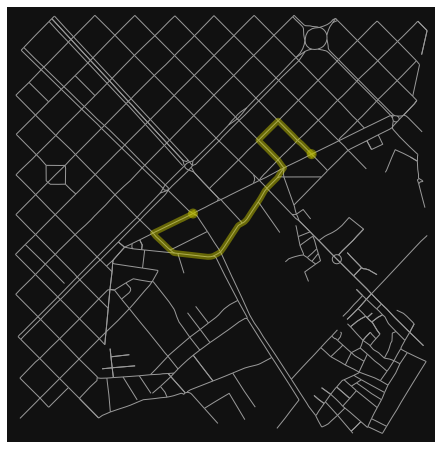

In [220]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G_zoom_drive)[1]
dest = list(G_zoom_drive)[6]
#origin = (intersections[0].centroid.x,intersections[0].centroid.y)
#destination = (intersections[274].centroid.x,intersections[274].centroid.y)
#origin_node = ox.get_nearest_node(G_zoom_drive, origin)
#destination_node = ox.get_nearest_node(G_zoom_drive, destination)

route = ox.shortest_path(G_zoom_drive, orig, dest, weight='length')
fig, ax = ox.plot_graph_route(G_zoom_drive, route, route_color='y', route_linewidth=6, node_size=0)

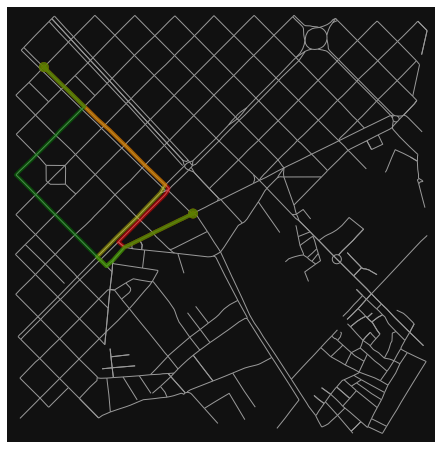

In [191]:
routes = ox.k_shortest_paths(G_zoom_drive, orig, dest, k=3, weight='length') # number of shortest paths
fig, ax = ox.plot_graph_routes(G_zoom_drive, list(routes), route_colors=['r','y','g'], route_linewidth=4, node_size=0)

## Imputing travel speeds and times

In [193]:
# Since we dont have spped limits predetermined we use hwy_speed dict
hwy_speeds = {'residential': 35,
              'living_street': 20,
              'secondary': 50,
              'tertiary': 60}
G_zoom_drive = ox.add_edge_speeds(G_zoom_drive, hwy_speeds)

In [194]:
# calculate edge travel times
G_zoom_drive = ox.add_edge_travel_times(G_zoom_drive)

In [196]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G_zoom_drive, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['living_street', 'residential']",113.9,27.5,14.8
"['living_street', 'tertiary']",136.1,25.0,19.6
"['secondary', 'tertiary']",63.6,40.0,5.7
living_street,125.2,18.3,29.6
primary,82.8,50.0,6.0
primary_link,127.8,42.9,11.5
residential,88.9,30.1,10.7
secondary,93.1,50.0,6.7
secondary_link,54.0,50.0,3.9


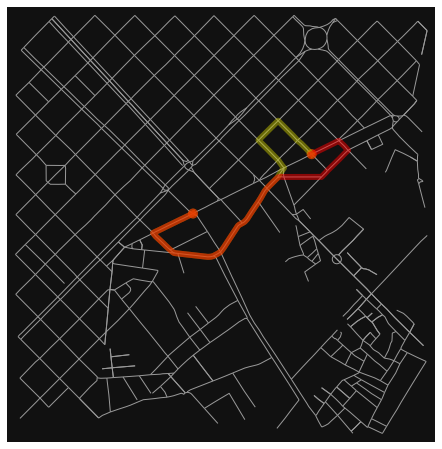

In [210]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G_zoom_drive)[1]
dest = list(G_zoom_drive)[6]
route1 = ox.shortest_path(G_zoom_drive, orig, dest, weight='length')
route2 = ox.shortest_path(G_zoom_drive, orig, dest, weight='travel_time')

# plot the routes
fig, ax = ox.plot_graph_routes(G_zoom_drive, routes=[route1, route2], route_colors=['y', 'r'],
                               route_linewidth=6, node_size=0)

Compare the two routes 

In [212]:
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_zoom_drive, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_zoom_drive, route2, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G_zoom_drive, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G_zoom_drive, route2, 'travel_time')))
print('Route 1 is', route1_length, 'meters and takes', route1_time, 'seconds.')
print('Route 2 is', route2_length, 'meters and takes', route2_time, 'seconds.')

Route 1 is 1617 meters and takes 131 seconds.
Route 2 is 1621 meters and takes 119 seconds.


### Route from coordinates 

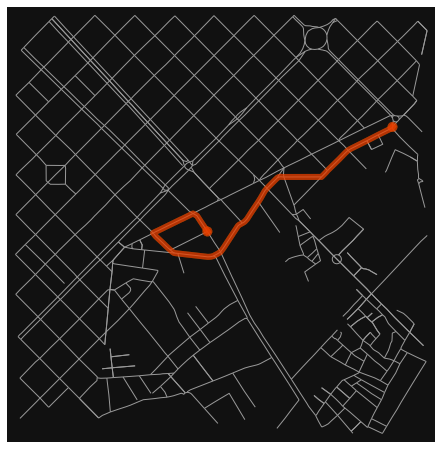

In [214]:
origin = (41.387026, 2.170115)
destination = (41.391055, 2.180111)
origin_node = ox.get_nearest_node(G_zoom_drive, origin)
destination_node = ox.get_nearest_node(G_zoom_drive, destination)
route1 = ox.shortest_path(G_zoom_drive, origin_node, destination_node, weight='length')
route2 = ox.shortest_path(G_zoom_drive, origin_node, destination_node, weight='travel_time')
# plot the routes
fig, ax = ox.plot_graph_routes(G_zoom_drive, routes=[route1, route2], route_colors=['y', 'r'],
                               route_linewidth=6, node_size=0)